In [33]:
# Importação dos pacotes
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.io as pio
pio.renderers.default = 'notebook'

from scipy.stats import norm
import scipy.stats as stats

import statsmodels.api as sm # estimação de modelos

from statstests.process import stepwise # procedimento Stepwise


### DIAGNÓSTICO DE HETEROCEDASTICIDADE EM MODELOS DE REGRESSÃO

EXEMPLO 7

Vamos valiar a corr[$X_i$, $\mu_i$]. Existe correlação?

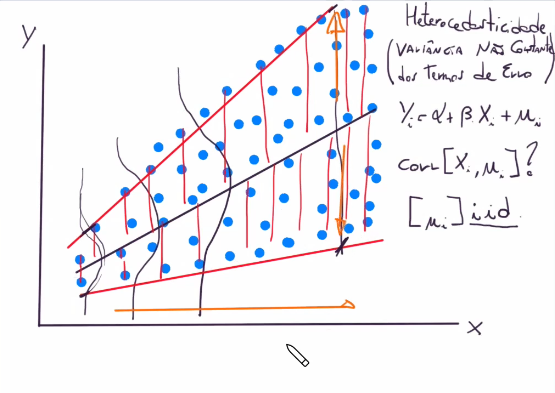

Termos de erro
- independentes
- identicamente distribuídos

- Quem faz as vezes dos termos de erro? As variáveis que não foram consideradas no modelo!
- Então os termos de erro $u_i$ indicam a omissão de variável relevante X no modelo final.

Pra que serve o diagnóstico de heterocetisticidade?
Ela mostra se tem variáveis X relevantes, omitidas.

Vamos então verificar se: 

$corr$ [$X_i$, $\mu_i$] $\not =$ 0

In [34]:
df_saeb_rend = pd.read_csv('/home/usp_ds_analytics/regression_analysis/data/saeb_rend.csv', delimiter=',')
df_saeb_rend.head()

,uf,municipio,codigo,escola,rede,saeb,rendimento
0,RO,Alta Floresta D'Oeste,11024666,EMEIEF BOA ESPERANCA,Municipal,5.331833,0.766092
1,RO,Alta Floresta D'Oeste,11024682,EEEF EURIDICE LOPES PEDROSO,Estadual,NaN,0.910890
2,RO,Alta Floresta D'Oeste,11024828,EMEIEF IZIDORO STEDILE,Municipal,5.432333,0.884658
3,RO,Alta Floresta D'Oeste,11024917,EMEIEF JOSE BASILIO DA GAMA,Municipal,NaN,NaN
4,RO,Alta Floresta D'Oeste,11024968,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,5.568833,0.957629


In [35]:
# Características das variáveis do dataset
df_saeb_rend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43607 entries, 0 to 43606
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uf          43607 non-null  object 
 1   municipio   43607 non-null  object 
 2   codigo      43607 non-null  int64  
 3   escola      43607 non-null  object 
 4   rede        43607 non-null  object 
 5   saeb        25538 non-null  float64
 6   rendimento  37324 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.3+ MB


In [36]:
# Estatísticas univariadas
df_saeb_rend.describe(include='all')

,uf,municipio,codigo,escola,rede,saeb,rendimento
count,43607,43607,4.360700e+04,43607,43607,25538.000000,37324.000000
unique,27,5296,NaN,41649,3,NaN,NaN
top,SP,São Paulo,NaN,EE SAO JOSE,Municipal,NaN,NaN
freq,5753,1208,NaN,16,22610,NaN,NaN
mean,NaN,NaN,3.112734e+07,NaN,NaN,5.047511,0.856967
std,NaN,NaN,9.956731e+06,NaN,NaN,0.753718,0.110447
min,NaN,NaN,1.100026e+07,NaN,NaN,2.053000,0.247282
25%,NaN,NaN,2.316996e+07,NaN,NaN,4.554542,0.791561
50%,NaN,NaN,3.108142e+07,NaN,NaN,5.069500,0.878536
75%,NaN,NaN,3.590717e+07,NaN,NaN,5.551458,0.944761


Ops, código está como int64 - NÃOOOOOOOOOO.

Ele é considerado uma categoria, então precisamos corrigir isso.

In [37]:
df_saeb_rend['codigo'] = df_saeb_rend['codigo'].astype('str')

In [38]:
df_saeb_rend['codigo'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 43607 entries, 0 to 43606
Series name: codigo
Non-Null Count  Dtype 
--------------  ----- 
43607 non-null  object
dtypes: object(1)
memory usage: 340.8+ KB


In [39]:
### Tabela de frequências absolutas das variáveis 'uf' e rede'
df_saeb_rend['uf'].value_counts().sort_index()

uf
AC     204
AL     718
AM     972
AP     172
BA    3539
CE    2971
DF     217
ES     831
GO    1400
MA    2761
MG    4399
MS     643
MT     966
PA    2046
PB    1075
PE    1866
PI    1289
PR    1886
RJ    2310
RN     859
RO     468
RR     128
RS    3315
SC    1742
SE     562
SP    5753
TO     515
Name: count, dtype: int64

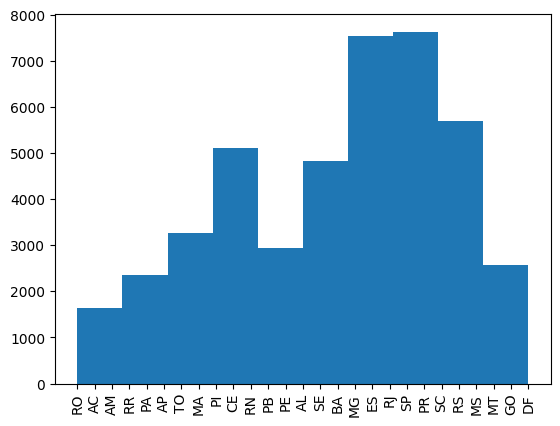

In [40]:
plt.hist(df_saeb_rend['uf'])
plt.xticks(rotation=90)
plt.show()

In [41]:
df_saeb_rend['rede'].value_counts().sort_index()

rede
Estadual     20959
Federal         38
Municipal    22610
Name: count, dtype: int64

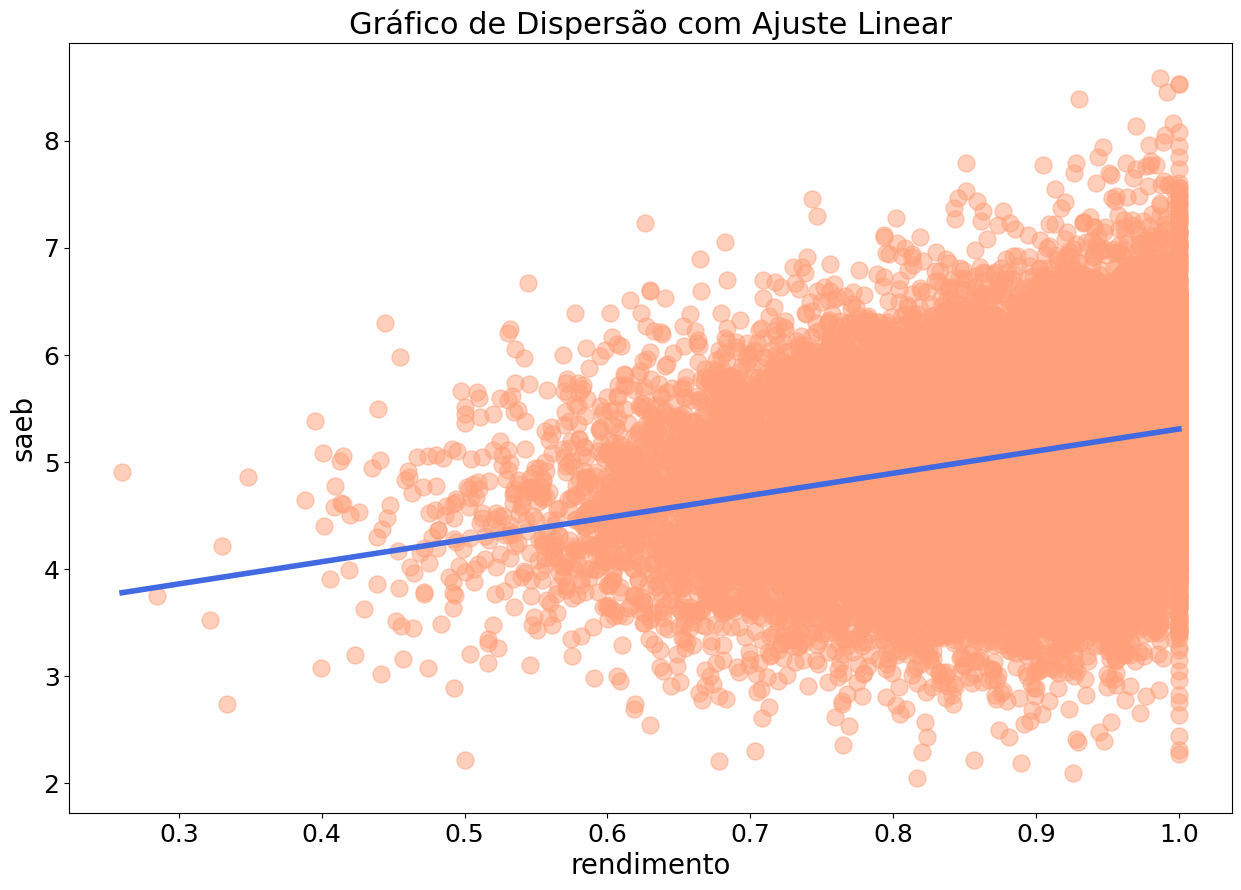

In [42]:
# Plotando a variável 'saeb' em função de 'rendimento', com fit linear
# Gráfico pela função 'regplot' do 'seaborn'
plt.figure(figsize=(15,10))
sns.regplot(x='rendimento', y='saeb', data=df_saeb_rend, marker='o',
            color='royalblue', ci=False,
            scatter_kws={'color':'lightsalmon', 'alpha':0.5, 's':150},
            line_kws={'linewidth': 4})
plt.title('Gráfico de Dispersão com Ajuste Linear', fontsize=22)
plt.xlabel('rendimento', fontsize=20)
plt.ylabel('saeb', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

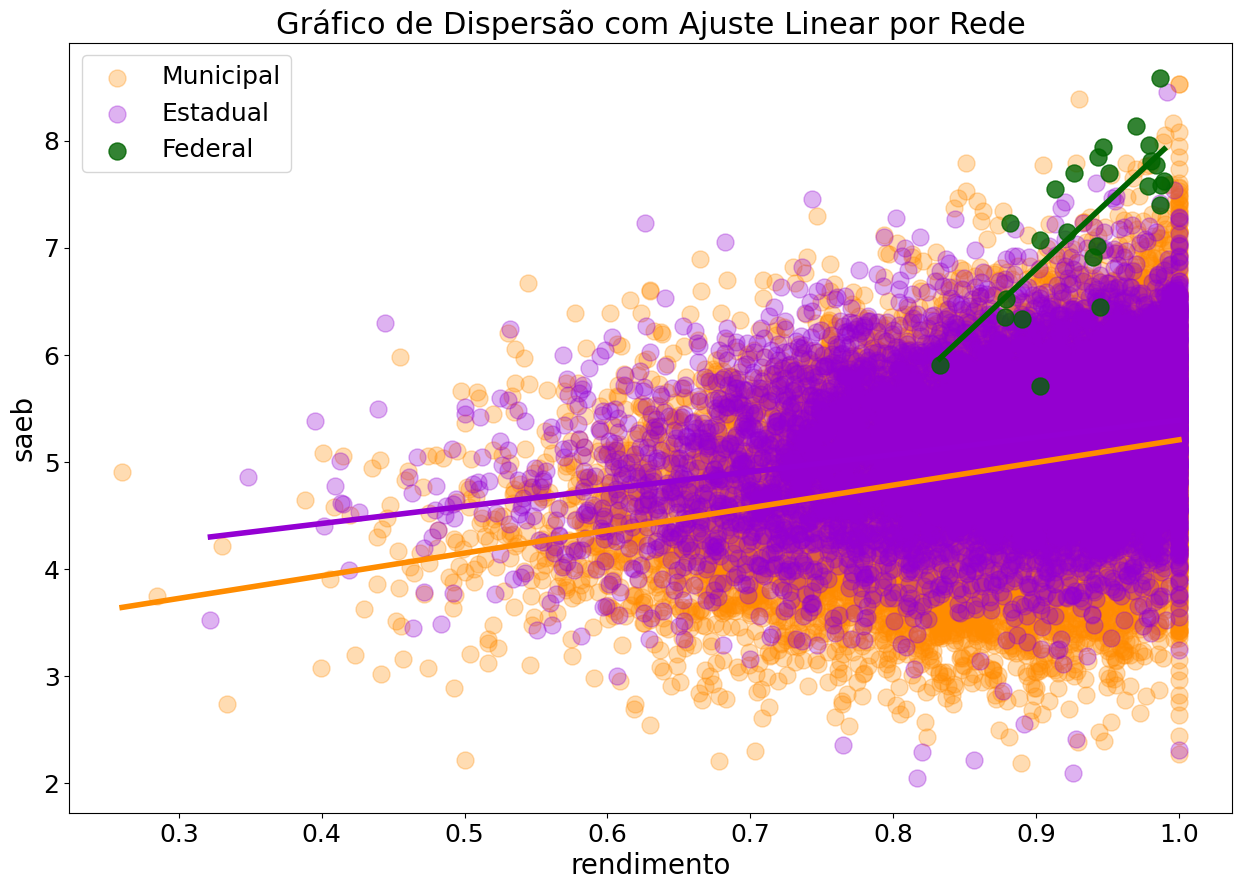

In [43]:
# Plotando a variável 'saeb' em função de 'rendimento', com destaque
#para a 'rede' escolar e linear fits -> Gráfico pela função 'regplot' do
#pacote 'seaborn'
# Definição de dataframes com subgrupos por 'rede'
df1 = df_saeb_rend[df_saeb_rend['rede'] == 'Municipal']
df2 = df_saeb_rend[df_saeb_rend['rede'] == 'Estadual']
df3 = df_saeb_rend[df_saeb_rend['rede'] == 'Federal']

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.regplot(x='rendimento', y='saeb', data=df1, marker='o', ci=False,
            scatter_kws={'color':'darkorange', 'alpha':0.3, 's':150},
            line_kws={'color':'darkorange', 'linewidth': 4}, label='Municipal')
sns.regplot(x='rendimento', y='saeb', data=df2, marker='o', ci=False,
            scatter_kws={'color':'darkviolet', 'alpha':0.3, 's':150},
            line_kws={'color':'darkviolet', 'linewidth': 4}, label='Estadual')
sns.regplot(x='rendimento', y='saeb', data=df3, marker='o', ci=False,
            scatter_kws={'color':'darkgreen', 'alpha':0.8, 's':150},
            line_kws={'color':'darkgreen', 'linewidth': 4}, label='Federal')
plt.title('Gráfico de Dispersão com Ajuste Linear por Rede', fontsize=22)
plt.xlabel('rendimento', fontsize=20)
plt.ylabel('saeb', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

### Estimação do modelo de regressão e diagnóstico de heterocedasticidade

In [44]:
# Estimando o modelo
modelo_saeb = sm.OLS.from_formula('saeb ~ rendimento', df_saeb_rend).fit()

# Parâmetros do 'modelo_saeb'
modelo_saeb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   saeb   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2126.
Date:                Sat, 24 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:36:02   Log-Likelihood:                -27984.
No. Observations:               25530   AIC:                         5.597e+04
Df Residuals:                   25528   BIC:                         5.599e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2425      0.039     82.277      0.000       3.165       3.320
rendimento     2.0665      0.045     46.111      0.000       1.979       2.154
==============================================================================
Omnibus:                      152.496   Durbin-Watson:                   1.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.269
Skew:                          -0.091   Prob(JB):                     1.97e-44
Kurtosis:                       3.395   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- R-squared muito baixo
- Prob (F-statistic):	0.00

In [45]:
# Adicionando fitted values e resíduos do 'modelo_saeb' no
# dataset 'df_saeb_rend'
df_saeb_rend['fitted'] = modelo_saeb.fittedvalues
df_saeb_rend['residuos'] = modelo_saeb.resid
df_saeb_rend.head()

,uf,municipio,codigo,escola,rede,saeb,rendimento,fitted,residuos
0,RO,Alta Floresta D'Oeste,11024666,EMEIEF BOA ESPERANCA,Municipal,5.331833,0.766092,4.825556,0.506278
1,RO,Alta Floresta D'Oeste,11024682,EEEF EURIDICE LOPES PEDROSO,Estadual,NaN,0.910890,NaN,NaN
2,RO,Alta Floresta D'Oeste,11024828,EMEIEF IZIDORO STEDILE,Municipal,5.432333,0.884658,5.070567,0.361767
3,RO,Alta Floresta D'Oeste,11024917,EMEIEF JOSE BASILIO DA GAMA,Municipal,NaN,NaN,NaN,NaN
4,RO,Alta Floresta D'Oeste,11024968,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,5.568833,0.957629,5.221359,0.347474


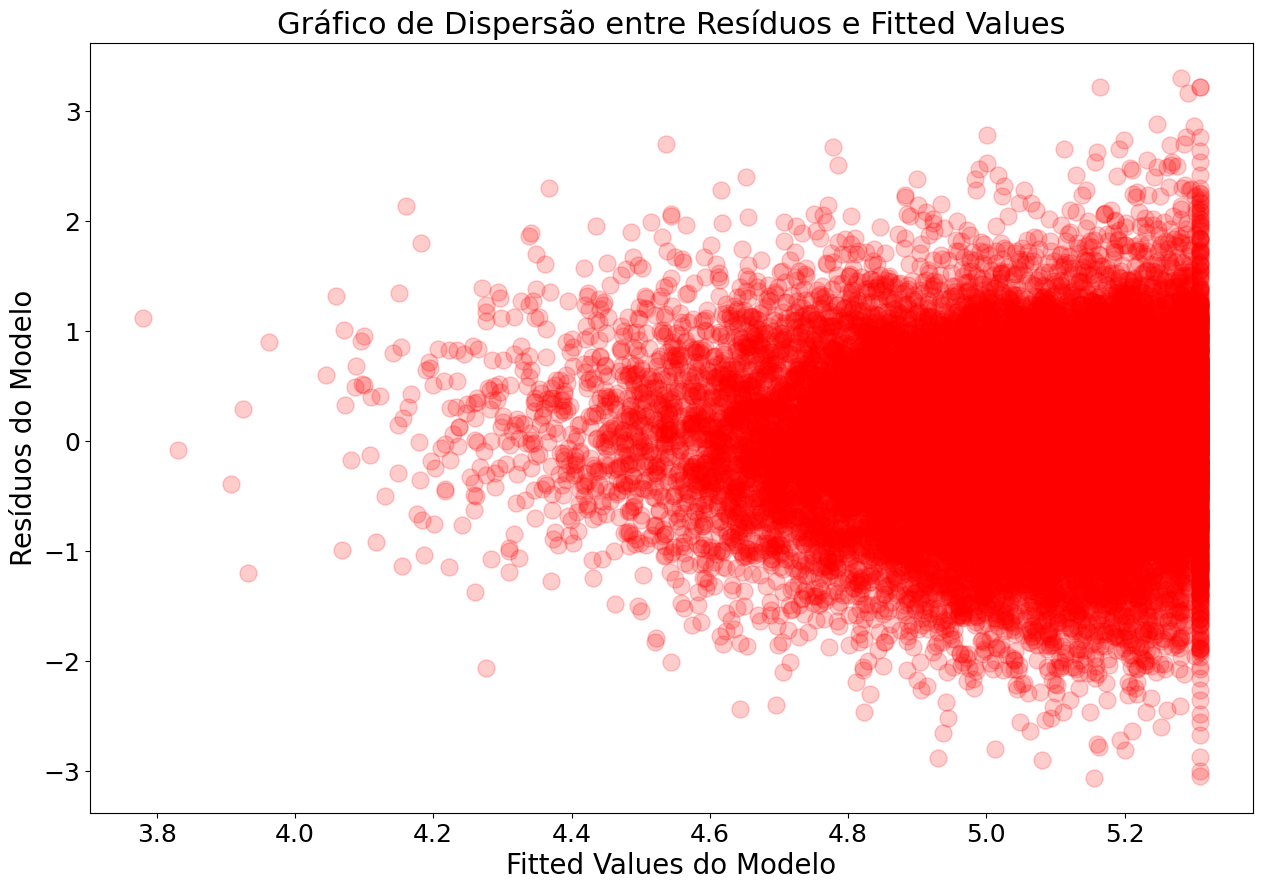

In [46]:
# Gráfico que relaciona resíduos e fitted values do 'modelo_saeb'
plt.figure(figsize=(15,10))
sns.regplot(x='fitted', y='residuos', data=df_saeb_rend,
            marker='o', fit_reg=False,
            scatter_kws={"color":'red', 'alpha':0.2, 's':150})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo', fontsize=20)
plt.ylabel('Resíduos do Modelo', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

- $\hat{y}$ são os valores previstos no modelo, e tem a variável preditora

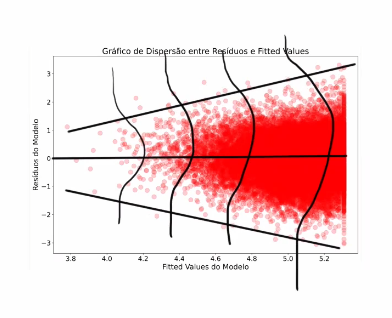

In [47]:
# Histograma dos resíduos do 'modelo_saeb' com curva normal teórica
#para comparação das distribuições
# Kernel density estimation (KDE) - forma não-paramétrica para estimação da
#função densidade de probabilidade de determinada variável

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_saeb.resid)

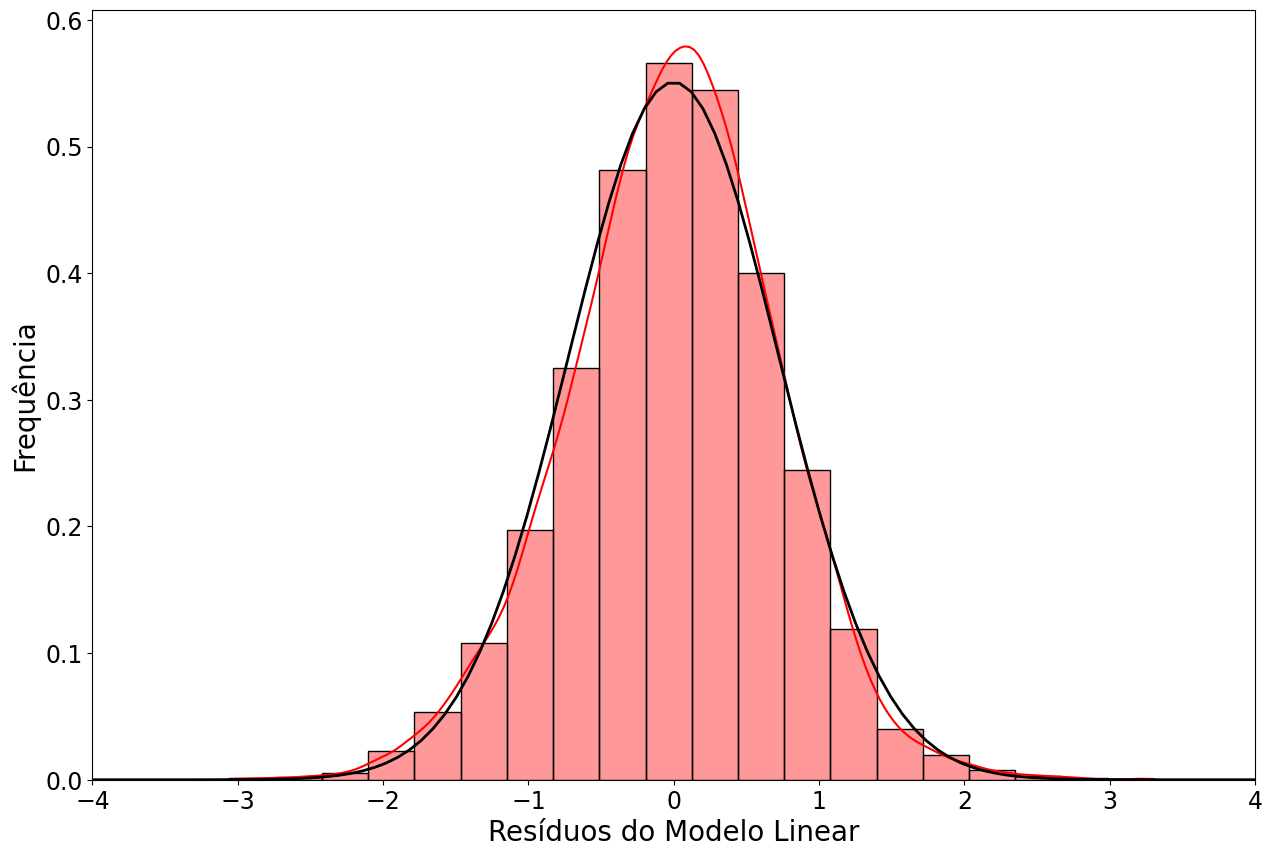

In [48]:
# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_saeb.resid, bins=20, kde=True, stat="density",
             color='red', alpha=0.4)
plt.xlim(-4, 4)
x = np.linspace(-4, 4, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

### teste de Breusch-Pagan
para a elaboração de diagnóstico de heterocedasticidade

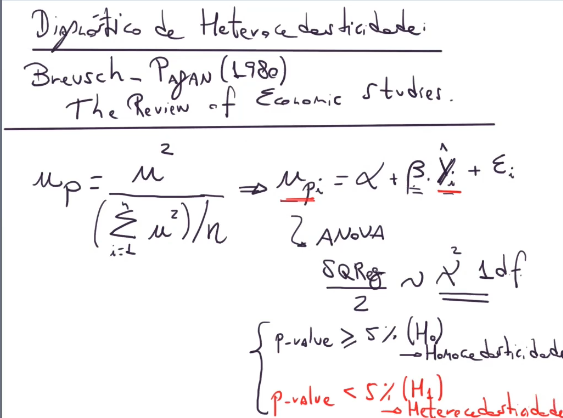

In [49]:
# Criação da função 'breusch_pagan_test'
def breusch_pagan_test(modelo):
    df = pd.DataFrame({'yhat':modelo.fittedvalues,
                       'resid':modelo.resid})
   
    df['up'] = (np.square(df.resid))/np.sum(((np.square(df.resid))/df.shape[0]))
    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()
    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)
    anova_table['sum_sq'] = anova_table['sum_sq']/2
    chisq = anova_table['sum_sq'].iloc[0]
    p_value = stats.chi2.pdf(chisq, 1)*2
    
    print(f"chisq: {chisq}")
    print(f"p-value: {p_value}")
    
    return chisq, p_value

In [50]:
# Teste de Breusch-Pagan propriamente dito
breusch_pagan_test(modelo_saeb)

chisq: 16.720700325953093
p-value: 4.565190314939393e-05


(np.float64(16.720700325953093), np.float64(4.565190314939393e-05))

Presença de heterocedasticidade -> omissão de variável(is) explicativa(s) relevante(s)

- H0 do teste: ausência de heterocedasticidade.
- H1 do teste: heterocedasticidade, ou seja, correlação entre resíduos e uma ou mais variáveis explicativas, o que indica omissão de variável relevante!


In [51]:
# Interpretação
teste_bp = breusch_pagan_test(modelo_saeb) #criação do objeto 'teste_bp'
chisq, p = teste_bp #definição dos elementos contidos no objeto 'teste_bp'
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 16.720700325953093
p-value: 4.565190314939393e-05
Rejeita-se H0 - Existência de Heterocedasticidade


### Procedimento n-1 dummies para as unidades federativas

In [52]:
df_saeb_rend.head()

,uf,municipio,codigo,escola,rede,saeb,rendimento,fitted,residuos
0,RO,Alta Floresta D'Oeste,11024666,EMEIEF BOA ESPERANCA,Municipal,5.331833,0.766092,4.825556,0.506278
1,RO,Alta Floresta D'Oeste,11024682,EEEF EURIDICE LOPES PEDROSO,Estadual,NaN,0.910890,NaN,NaN
2,RO,Alta Floresta D'Oeste,11024828,EMEIEF IZIDORO STEDILE,Municipal,5.432333,0.884658,5.070567,0.361767
3,RO,Alta Floresta D'Oeste,11024917,EMEIEF JOSE BASILIO DA GAMA,Municipal,NaN,NaN,NaN,NaN
4,RO,Alta Floresta D'Oeste,11024968,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,5.568833,0.957629,5.221359,0.347474


In [53]:
# Dummização da variável 'uf'
df_saeb_rend_dummies = pd.get_dummies(df_saeb_rend, columns=['uf'],
                                      dtype=int,
                                      drop_first=True)

df_saeb_rend_dummies.head()

,municipio,codigo,escola,rede,saeb,rendimento,fitted,residuos,uf_AL,uf_AM,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,Alta Floresta D'Oeste,11024666,EMEIEF BOA ESPERANCA,Municipal,5.331833,0.766092,4.825556,0.506278,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Alta Floresta D'Oeste,11024682,EEEF EURIDICE LOPES PEDROSO,Estadual,NaN,0.910890,NaN,NaN,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Alta Floresta D'Oeste,11024828,EMEIEF IZIDORO STEDILE,Municipal,5.432333,0.884658,5.070567,0.361767,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Alta Floresta D'Oeste,11024917,EMEIEF JOSE BASILIO DA GAMA,Municipal,NaN,NaN,NaN,NaN,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Alta Floresta D'Oeste,11024968,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,5.568833,0.957629,5.221359,0.347474,0,0,...,0,0,0,1,0,0,0,0,0,0


### Estimação do modelo de regressão múltipla com n-1 dummies

In [54]:
# Definição da fórmula utilizada no modelo
lista_colunas = list(df_saeb_rend_dummies.drop(columns=['municipio',
                                                        'codigo',
                                                        'escola',
                                                        'rede',
                                                        'saeb',
                                                        'fitted',
                                                        'residuos']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "saeb ~ " + formula_dummies_modelo

# Estimação
modelo_saeb_dummies_uf = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_saeb_rend_dummies).fit()

# Parâmetros do modelo 'modelo_saeb_dummies_uf'
modelo_saeb_dummies_uf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   saeb   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     497.5
Date:                Sat, 24 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:36:03   Log-Likelihood:                -23604.
No. Observations:               25530   AIC:                         4.726e+04
Df Residuals:                   25502   BIC:                         4.749e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7566      0.071     53.118      0.000       3.618       3.895
rendimento     1.2444      0.044     28.057      0.000       1.157       1.331
uf_AL         -0.1680      0.065     -2.589      0.010      -0.295      -0.041
uf_AM         -0.2480      0.063     -3.949      0.000      -0.371      -0.125
uf_AP         -0.5356      0.091     -5.900      0.000      -0.714      -0.358
uf_BA         -0.2451      0.060     -4.106      0.000      -0.362      -0.128
uf_CE          0.3591      0.059      6.072      0.000       0.243       0.475
uf_DF          0.4426      0.082      5.422      0.000       0.283       0.603
uf_ES          0.5843      0.064      9.197      0.000       0.460       0.709
uf_GO          0.4936      0.061      8.103      0.000       0.374       0.613
uf_MA         -0.6703      0.060    -11.194      0.000      -0.788      -0.553
uf_MG          0.3983      0.059      6.774      0.000       0.283       0.514
uf_MS          0.5386      0.067      8.087      0.000       0.408       0.669
uf_MT         -0.0836      0.064     -1.305      0.192      -0.209       0.042
uf_PA         -0.4627      0.060     -7.654      0.000      -0.581      -0.344
uf_PB         -0.0913      0.063     -1.438      0.151      -0.216       0.033
uf_PE         -0.0279      0.060     -0.461      0.645      -0.146       0.091
uf_PI         -0.1084      0.062     -1.759      0.079      -0.229       0.012
uf_PR          0.6130      0.061     10.112      0.000       0.494       0.732
uf_RJ          0.3945      0.060      6.531      0.000       0.276       0.513
uf_RN         -0.0996      0.067     -1.483      0.138      -0.231       0.032
uf_RO          0.3881      0.068      5.738      0.000       0.256       0.521
uf_RR         -0.2887      0.105     -2.742      0.006      -0.495      -0.082
uf_RS          0.7146      0.060     11.993      0.000       0.598       0.831
uf_SC          0.6930      0.060     11.483      0.000       0.575       0.811
uf_SE         -0.0072      0.067     -0.108      0.914      -0.138       0.124
uf_SP          0.4371      0.059      7.448      0.000       0.322       0.552
uf_TO          0.1189      0.067      1.782      0.075      -0.012       0.250
==============================================================================
Omnibus:                      575.254   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.751
Skew:                           0.147   Prob(JB):                    1.58e-244
Kurtosis:                       3.984   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Teste de Breusch-Pagan para diagnóstico de heterocedasticidade no 'modelo_saeb_dummies_uf'

In [55]:
# Interpretação
teste_bp = breusch_pagan_test(modelo_saeb_dummies_uf) #criação do objeto 'teste_bp'
chisq, p = teste_bp #definição dos elementos contidos no objeto 'teste_bp'
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 1.075624189838262
p-value: 0.44930469428887665
Não se rejeita H0 - Ausência de Heterocedasticidade


A inclusão de dummies eliminou a heterocedasticidade? Sim, pois temos outras variáveis que são estatisticamente relevantes.

Dumização da variável 'uf' com n dummies
- ao se alterar a categoria de referência da dummy em modelos multivariados, não muda o p-value no teste de Breusch-Pagan

### Estimação do modelo por meio do procedimento Stepwise

In [56]:
modelo_saeb_dummies_uf_step = stepwise(modelo_saeb_dummies_uf, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 saeb ~ Q('rendimento') + Q('uf_AL') + Q('uf_AM') + Q('uf_AP') + Q('uf_BA') + Q('uf_CE') + Q('uf_DF') + Q('uf_ES') + Q('uf_GO') + Q('uf_MA') + Q('uf_MG') + Q('uf_MS') + Q('uf_MT') + Q('uf_PA') + Q('uf_PB') + Q('uf_PE') + Q('uf_PI') + Q('uf_PR') + Q('uf_RJ') + Q('uf_RN') + Q('uf_RO') + Q('uf_RR') + Q('uf_RS') + Q('uf_SC') + Q('uf_SE') + Q('uf_SP') + Q('uf_TO')

 Discarding atribute "Q('uf_SE')" with p-value equal to 0.9137429906455955 

Estimating model...: 
 saeb ~ Q('rendimento') + Q('uf_AL') + Q('uf_AM') + Q('uf_AP') + Q('uf_BA') + Q('uf_CE') + Q('uf_DF') + Q('uf_ES') + Q('uf_GO') + Q('uf_MA') + Q('uf_MG') + Q('uf_MS') + Q('uf_MT') + Q('uf_PA') + Q('uf_PB') + Q('uf_PE') + Q('uf_PI') + Q('uf_PR') + Q('uf_RJ') + Q('uf_RN') + Q('uf_RO') + Q('uf_RR') + Q('uf_RS') + Q('uf_SC') + Q('uf_SP') + Q('uf_TO')

 Discarding atribute "Q('uf_PE')" with p-value equal to 0.5082456821070078 

Estimating model...: 
 saeb ~ Q('rendimento') + Q('uf_AL') + Q('uf

### Teste de Breusch-Pagan para diagnóstico de heterocedasticidade no 'modelo_saeb_dummies_uf_step'

In [57]:
breusch_pagan_test(modelo_saeb_dummies_uf_step)

chisq: 1.1613867930619532
p-value: 0.4142472959247345


(np.float64(1.1613867930619532), np.float64(0.4142472959247345))

In [58]:
# Interpretação
teste_bp = breusch_pagan_test(modelo_saeb_dummies_uf_step) #criação do objeto 'teste_bp'
chisq, p = teste_bp #definição dos elementos contidos no objeto 'teste_bp'
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')


chisq: 1.1613867930619532
p-value: 0.4142472959247345
Não se rejeita H0 - Ausência de Heterocedasticidade


In [59]:
# Adicionando fitted values e resíduos do 'modelo_saeb_dummies_uf_step'
#no dataset 'df_saeb_rend'
df_saeb_rend['fitted_step'] = modelo_saeb_dummies_uf_step.fittedvalues
df_saeb_rend['residuos_step'] = modelo_saeb_dummies_uf_step.resid
df_saeb_rend.head()


,uf,municipio,codigo,escola,rede,saeb,rendimento,fitted,residuos,fitted_step,residuos_step
0,RO,Alta Floresta D'Oeste,11024666,EMEIEF BOA ESPERANCA,Municipal,5.331833,0.766092,4.825556,0.506278,5.098167,0.233666
1,RO,Alta Floresta D'Oeste,11024682,EEEF EURIDICE LOPES PEDROSO,Estadual,NaN,0.910890,NaN,NaN,NaN,NaN
2,RO,Alta Floresta D'Oeste,11024828,EMEIEF IZIDORO STEDILE,Municipal,5.432333,0.884658,5.070567,0.361767,5.245614,0.186719
3,RO,Alta Floresta D'Oeste,11024917,EMEIEF JOSE BASILIO DA GAMA,Municipal,NaN,NaN,NaN,NaN,NaN,NaN
4,RO,Alta Floresta D'Oeste,11024968,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,5.568833,0.957629,5.221359,0.347474,5.336360,0.232473


In [62]:
modelo_saeb_dummies_uf_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   saeb   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     610.0
Date:                Sat, 24 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:39:16   Log-Likelihood:                -23609.
No. Observations:               25530   AIC:                         4.726e+04
Df Residuals:                   25507   BIC:                         4.745e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.7042      0.038     97.666      0.000       3.630       3.779
Q('rendimento')     1.2436      0.043     29.159      0.000       1.160       1.327
Q('uf_AL')         -0.1148      0.032     -3.628      0.000      -0.177      -0.053
Q('uf_AM')         -0.1948      0.027     -7.134      0.000      -0.248      -0.141
Q('uf_AP')         -0.4825      0.071     -6.806      0.000      -0.622      -0.344
Q('uf_BA')         -0.1921      0.018    -10.502      0.000      -0.228      -0.156
Q('uf_CE')          0.4123      0.018     23.494      0.000       0.378       0.447
Q('uf_DF')          0.4957      0.059      8.437      0.000       0.381       0.611
Q('uf_ES')          0.6374      0.029     22.184      0.000       0.581       0.694
Q('uf_GO')          0.5468      0.023     23.844      0.000       0.502       0.592
Q('uf_MA')         -0.6171      0.019    -31.718      0.000      -0.655      -0.579
Q('uf_MG')          0.4515      0.016     28.371      0.000       0.420       0.483
Q('uf_MS')          0.5917      0.035     16.856      0.000       0.523       0.661
Q('uf_PA')         -0.4096      0.021    -19.605      0.000      -0.451      -0.369
Q('uf_PI')         -0.0553      0.024     -2.278      0.023      -0.103      -0.008
Q('uf_PR')          0.6662      0.022     30.513      0.000       0.623       0.709
Q('uf_RJ')          0.4476      0.021     21.581      0.000       0.407       0.488
Q('uf_RO')          0.4413      0.037     11.870      0.000       0.368       0.514
Q('uf_RR')         -0.2356      0.089     -2.652      0.008      -0.410      -0.061
Q('uf_RS')          0.7677      0.018     41.923      0.000       0.732       0.804
Q('uf_SC')          0.7461      0.021     35.278      0.000       0.705       0.788
Q('uf_SP')          0.4903      0.016     30.349      0.000       0.459       0.522
Q('uf_TO')          0.1720      0.035      4.868      0.000       0.103       0.241
==============================================================================
Omnibus:                      578.119   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1131.238
Skew:                           0.148   Prob(JB):                    2.26e-246
Kurtosis:                       3.988   Cond. No.                         31.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

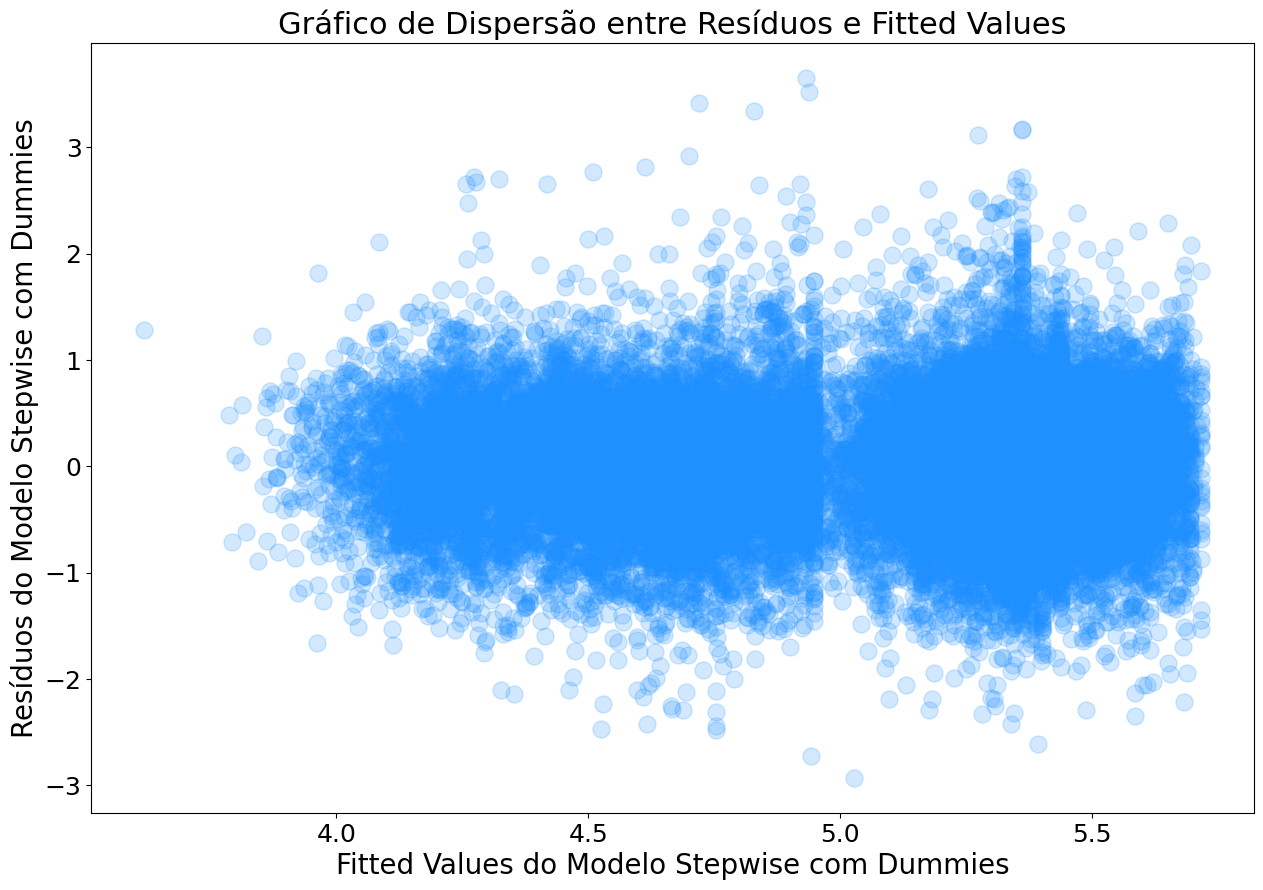

In [60]:
# Gráfico que relaciona resíduos e fitted values do
#'modelo_saeb_dummies_uf_step'
plt.figure(figsize=(15,10))
sns.regplot(x='fitted_step', y='residuos_step', data=df_saeb_rend,
            marker='o', fit_reg=False,
            scatter_kws={"color":'dodgerblue', 'alpha':0.2, 's':150})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo Stepwise com Dummies', fontsize=20)
plt.ylabel('Resíduos do Modelo Stepwise com Dummies', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

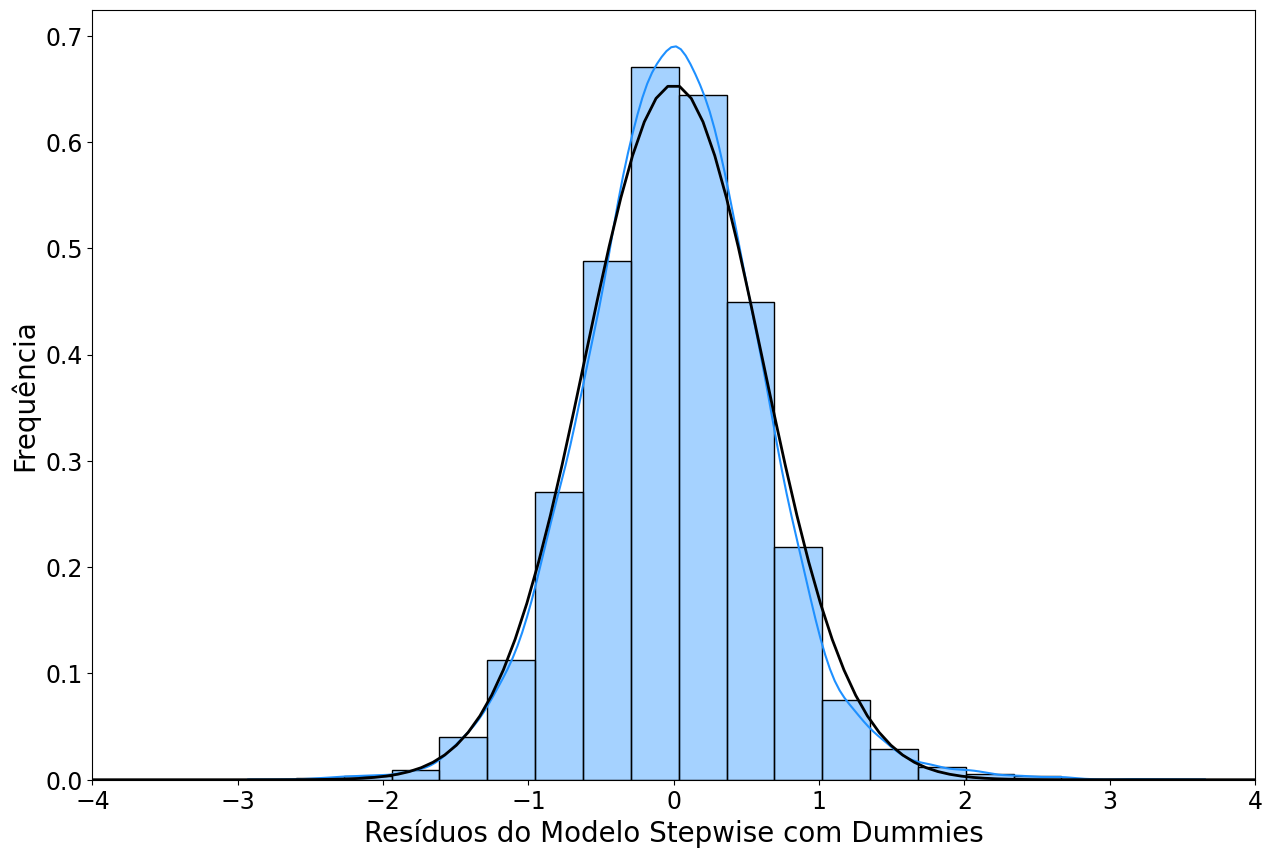

In [63]:
# Histograma dos resíduos do 'modelo_saeb_dummies_uf_step' com curva
#normal teórica para comparação das distribuições
# Kernel density estimation (KDE) - forma não-paramétrica para estimação da
#função densidade de probabilidade de determinada variável

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_saeb_dummies_uf_step.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_saeb_dummies_uf_step.resid, bins=20, kde=True,
             stat="density", color='dodgerblue', alpha=0.4)
plt.xlim(-4, 4)
x = np.linspace(-4, 4, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Stepwise com Dummies', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

<Figure size 1500x1000 with 0 Axes>

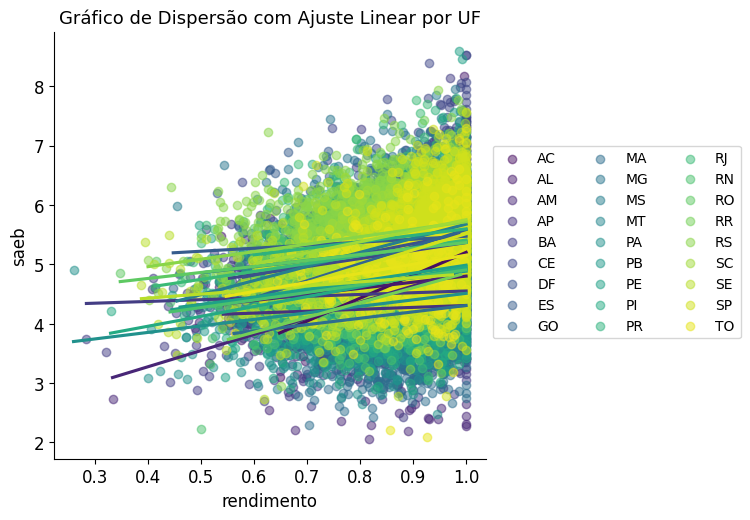

In [64]:
# Plotando a variável 'saeb' em função de 'rendimento', com destaque
#para as unidades federativas e fits lineares - Gráfico pela função 'lmplot' do
#pacote 'seaborn', com estratificação de 'uf' pelo argumento 'hue'

uf_order = df_saeb_rend['uf'].value_counts().index.sort_values()

plt.figure(figsize=(15, 10))
sns.lmplot(x='rendimento', y='saeb', data=df_saeb_rend,
           hue='uf', ci=None, palette='viridis', legend=False,
           scatter_kws={'alpha': 0.5},
           hue_order=uf_order)
plt.title('Gráfico de Dispersão com Ajuste Linear por UF', fontsize=13)
plt.xlabel('rendimento', fontsize=12)
plt.ylabel('saeb', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10, ncol=3, bbox_to_anchor=(1, 0.75))
plt.show()